In [86]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

#Our helpers
from map_helpers import *
from data_helpers import *
from analysis_helpers import *
from plot_helper import *
from helpers import *

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE

import json
import folium
from folium import plugins

#Plot data
import seaborn as sns

from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras import optimizers

%matplotlib inline
%reload_ext autoreload
%autoreload 2

For a better vizualisation of this notebook please read it using the [notebook viewer](https://nbviewer.jupyter.org/github/cgallay/Ada/blob/master/Project/Projet_ADA_M2.ipynb)

# Introduction to the million song Dataset

According to the web site :  https://labrosa.ee.columbia.edu/millionsong "The Million Song Dataset is a freely-available collection of audio features and metadata for a million contemporary popular music tracks.
The core of the dataset is the feature analysis and metadata for one million songs, provided by The Echo Nest. The dataset does not include any audio, only the derived features."

The entire dataset size is 280 GB. We however, based our final analysis on a subset of roughly 100,000 songs. We decided not tu use spark as we could manage a third of the dataset with standard methods and was a sufficiant size for our analysis.

You will see below the first steps of our approach.

### Features description : 
The list of the 54 features present in the dataset, can be found here : https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description
In order not to list them all we choose here to describe the one that seems reelevent to our project: 

 * **artist_name** 
 * **artist latitude:**	float	latitude
 * **artist longitude:** float	longitude
 * **artist_terms:** tags from The Echo Nest in float with range : [0:1]
 * **artist_terms_freq:** similar to mbtags_count but from Echo Nest in float with range : [0:1]  
 * **artist_terms_weight:** same shape as the two previous tags in float with range : [0:1]
 * **loudness:** the overall loudness of a track in decibels (dB). Loudness values in the Analyzer are averaged across an entire track and are useful for comparing relative loudness of segments and tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude).
 * **song_hotttnesss:** according to The Echo Nest, when downloaded (in December 2010) in float with range [0:1]
 * **segments_pitches** The key is a track-level attribute with range : [0:11] and corresponding to one of the 12 keys: C, C#, D, etc. up to B. If no key was detected, the value is -1. The mode is equal to 0 or 1 for “minor” or “major” and may be -1 in case of no result.
 * **segments_timbre** timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness.
 * **tempo:** tempo in BPM according to The Echo Nest
 * **title**
 * **year:** when this song was released, according to musicbrainz.org

# Importing Data
We proceded in two steps:

- Firtly, we loaded the dataset by batches and, for each of them, we extracted the useful features. We saved all the data in pickle formats for faster loading.

- Secondly, we loaded the corresponding pickles according to our needs.

In [ ]:
#Generating all pickles (WARNING: Takes ~2 Hours)
for letter in ['A', 'B', 'C', 'D', 'E', 'F']:
    for half in [1, 2]:
        df = load_song_data(letter, half)
        df1 = select_col(filter_year(df), part=1).dropna()
        df2 = select_col(exctract_timbre_features(filter_hotness(df, 0.001)), part=2).dropna()
        save_pickle_filtered(df1, letter, part=1, half=half)
        save_pickle_filtered(df2, letter, part=2, half=half)
        del df, df1, df2

In [2]:
#Load data
df_song1 = merge_pickles(['A', 'B', 'C', 'D', 'E', 'F'], part=1)

#Load for part2
df_song2 = merge_pickles(['A', 'B', 'C', 'D', 'E', 'F'], 2)
df_song2 = df_song2.sort_values('song_hotttnesss', ascending=False)
df_song2 = df_song2.reset_index()

As a lot of songs are unknown and not so popular, we further decided to filter the tracks according to their hotttnesss (popularity) feature. We, then, took the first 30000 songs and completed the data with help of the Deezer and spotify API to add a preview to listen fo each song.

In [3]:
#work only with the top 30'000 popular songs
df_song2 = df_song2[:30000]

In [ ]:
#extend data with preview
df_deezer = add_previews_deezer(df_song2)
df_spotify = add_previews_spotify(df_song2)
df_song2 = complete_previews(df_deezer, df_spotify, './pickle_data/complete_song_previews_url_completed_ABCDEF_0-30000.pkl')

In [4]:
#Fast reloading
df_song2 = pd.read_pickle('./pickle_data/complete_song_previews_url_completed_ABCDEF_0-30000.pkl')

In [5]:
print(f"We are working with a dataset of {len(df_song1)} songs in part one and of {len(df_song2)} songs in part two")

We are working with a dataset of 43383 songs in part one and of 30000 songs in part2


## Part 0: Exploration

### Year feature 
We started by checking the distribution of the song according to their year of realease

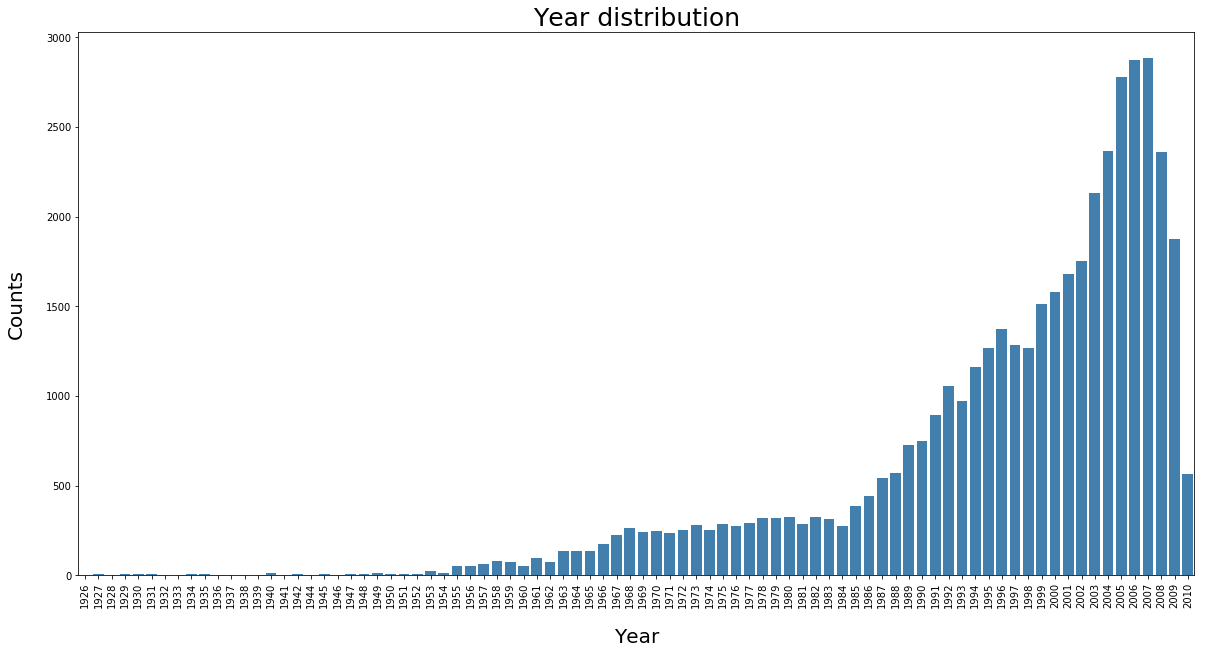

In [6]:
#Plot distribution by year
df = df_song1.groupby('year').count()

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plot = sns.barplot(x=df.index, y=df.artist_latitude, color='#3182bd')
plot.set_title('Year distribution', fontsize= 25 )
plot.set_ylabel('Counts', fontsize=20, labelpad=20)
plot.set_xlabel('Year', fontsize=20, labelpad=20)
plt.savefig('../docs/images/year_distr.png')
plt.show()

From this distribution we can see that the dataset contains much more sample starting from the 90's. This could be related to the emergence of the compact disc technology developed by Sony and Philips and launched in 1982 in which much more informations could be stored.
However, we can see bellow that the number of samples that do not contain a value for the feature "year" is not negligeable and represent almost half of our dataset. It will thus be necessary to take this into account analysing the whole dataset or find a way to extract this information from the web.

## Part 1: Discovering Genre through time

### Genre distribution on map

Here we want to have a look at distribution of artist per genre and per year, to see if it is possible to determine where genre where first recorded.

First of all we show bellow the distribution of artist in all time. We clearly see as already mention before a disproportion of location tag on song from our dataset. Most of the tags are either North America or in EU. As this wont let us detect musical style coming from Asia, South America or Africa, we should still be able to see from which side of the Atlantic the genre originate form.


In [7]:
artistDensityMap(df_song1)

### Selecting genre

To detect the genre of a song we based our analysis on the `artist_terms` attribute. Unfortunately this feature doesn't directly contain the genre of the artist (song), but rather terms that people have associated with this artist, most of the time this terms do correspond to genre but they might also be noise (such as a city). An other drawback of this feature, is that there is a lot of different sub-genre. To deal with that, we performed LDA (Latent Dirichlet Analysis) to find 10 super-genre. 

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobservedgroups that explain why some parts of the data are similar. For example, in our case, if observations are terms in the list of each artist_terms feature's track, It would describe the feature as a mixture of a small number of topics and that each term's creation is attributable to one of the feature's topics. The topic here would be a genre and the aim here is thus to group the tags into bigger categories representing a type of music.

In order to match a certain track to a mixture of genre, we will use the above algorithm to be able to classify tags under a same genre abd find the following 10 topics. 
We can observe that the terms are, indeed, related to each other which is what we expected from the tags of a track.

We trained our LDA on the top songs from part 2 as we found more meaningfull topic that way

In [8]:
#Train the model (using data from part 2 which is larger)
LDA = LatentDirichletAllocation(10, learning_method='batch', random_state=42)
vectorizer, X = get_LDA_vectorizer_features(df_song2)
%time X_tranform = LDA.fit_transform(X)

CPU times: user 2min 9s, sys: 3.46 ms, total: 2min 9s
Wall time: 2min 9s


In [9]:
show_top_topic(LDA, vectorizer, top=8)

0            1            2                 3  \
Topic 0          folk      country        world          acoustic   
Topic 1   heavy metal  death metal        metal      thrash metal   
Topic 2           pop       guitar   soundtrack           classic   
Topic 3  classic rock     pop rock    hard rock         soft rock   
Topic 4          soul         jazz          r&b    easy listening   
Topic 5     downtempo     trip hop        house            techno   
Topic 6          rock         punk     hardcore               emo   
Topic 7       hip hop          rap       reggae             latin   
Topic 8       electro   electronic  electronica          synthpop   
Topic 9    indie rock        indie  alternative  alternative rock   

                    4                    5                 6                 7  
Topic 0     folk rock    singer-songwriter         classical         americana  
Topic 1   black metal    progressive metal        doom metal       power metal  
Topic 2  instrumental                vocal           england         beautiful  
Topic 3    blues-rock                blues  psychedelic rock  progressive rock  
Topic 4          funk               ballad       smooth jazz     united states  
Topic 5     breakbeat               trance         chill-out        deep house  
Topic 6       screamo        hardcore punk          pop punk     post-hardcore  
Topic 7       spanish  underground hip hop   underground rap      gangster rap  
Topic 8      new wave           industrial        electropop      experimental  
Topic 9     indie pop            post rock          shoegaze               00s

In [10]:
#Add the super genre to the DataFrame
df_song1["genre"] = np.argmax(LDA.transform(get_LDA_features(df_song1, vectorizer)), axis=1)
df_song2["genre"] = np.argmax(X_tranform, axis=1)

In [11]:
showMapWithTime(selectGenre(df_song1, 2))

Below, we have a distribution of the genre

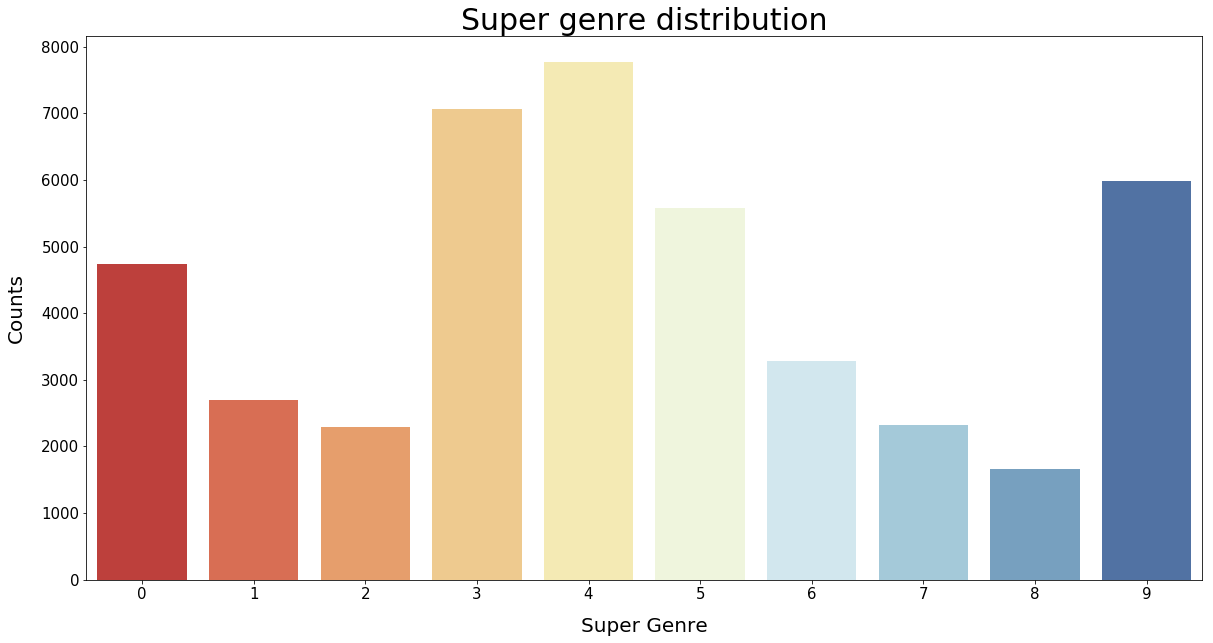

In [12]:
#Plot distribution by year
df = df_song1[['genre', 'year']].groupby('genre').count()

plt.figure(figsize=(20,10))
plot = sns.barplot(x=df.index, y=df.year, order=df.index, palette='RdYlBu')
plot.set_title('Super genre distribution', fontsize=30)
plot.set_ylabel('Counts', fontsize=20, labelpad=15)
plot.set_xlabel('Super Genre', fontsize=20, labelpad=15)
plot.xaxis.axes.tick_params(labelsize=15)
plot.yaxis.axes.tick_params(labelsize=15)
plt.savefig('../docs/images/genre_distr.png')
plt.show()

### Extending data through time

When vizualizing the song through time on the map we realised that a song only say one epoch (frame) visible. For us it doesn't reflect the reality as once a song is released it will perdure for a certain amount of time. To simulate that we extend our data with duplicate of the song up to 10 years after it's first apparition. We didn't want to naively duplicate the song as it wont stay a new song for 10 year long, to take that into account, as time pass we decrease the song weight (it's importance at representing the genre into the society)

In [13]:
showMapWithTimeAndWeight(extendsData(selectGenre(df_song1, 6)), htmlFilename='outputMap.html')

## Part 2: Discovering Genre through space

Now, lets try to put our genre classification into another perspective. More precisely, we want to confront the given labeling (tags) of the songs with some of their content informations. To do that, we focused on these given features : "tempo","loudness","time_signature","mode" with respect to the our genre labeling. However, we can see below, that the box plots for the features : “loudness”, “tempo” and “time signature” are not really relevant with respect to the defined genres.

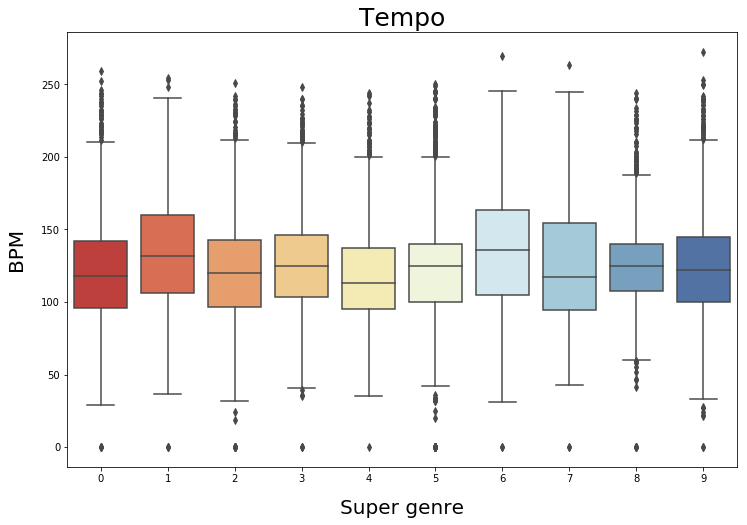

In [21]:
genre_boxplot(df_song2, y='tempo', y_label='BPM', title='Tempo', filename='../docs/images/box_plot_tempo.png')

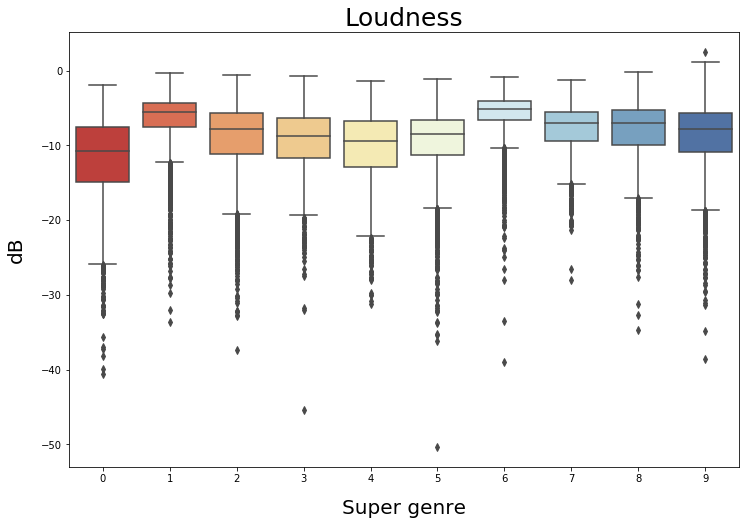

In [22]:
genre_boxplot(df_song2, y='loudness', y_label='dB', title='Loudness', filename='../docs/images/box_plot_loudness.png')

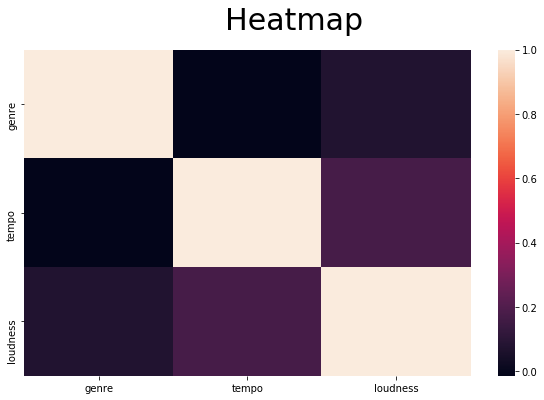

In [24]:
df4 = df_song2[["genre","tempo","loudness"]].corr()
fig = plt.figure(figsize=(10,6))
fig.suptitle("Heatmap", size=30)

plot = sns.heatmap(df4, annot=False)
sns.set(font_scale=1.7)

plt.savefig('../docs/images/heatmap.png')

plt.show()

### PCA
In order to see if we could get information from it, we started by applying on the vectors of a given super genre, a principal component analysis (PCA). PCA, is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. We can see below, that the representation in space of two sets of songs, (coming from two different genre with respect to their two principal components values give some relevant results. Indeed, we can see well defined separation between the two music genre.

In [51]:
segmTimb17 =  df_song2[["genre","X_mean"]][(df_song2["genre"] == 1) | (df_song2["genre"] == 7)]
X_content17 = segmTimb39['X_mean'].astype(list).tolist()
X_content17 = np.array(X_content17)
pca = PCA(n_components = 2).fit_transform(X_content17)

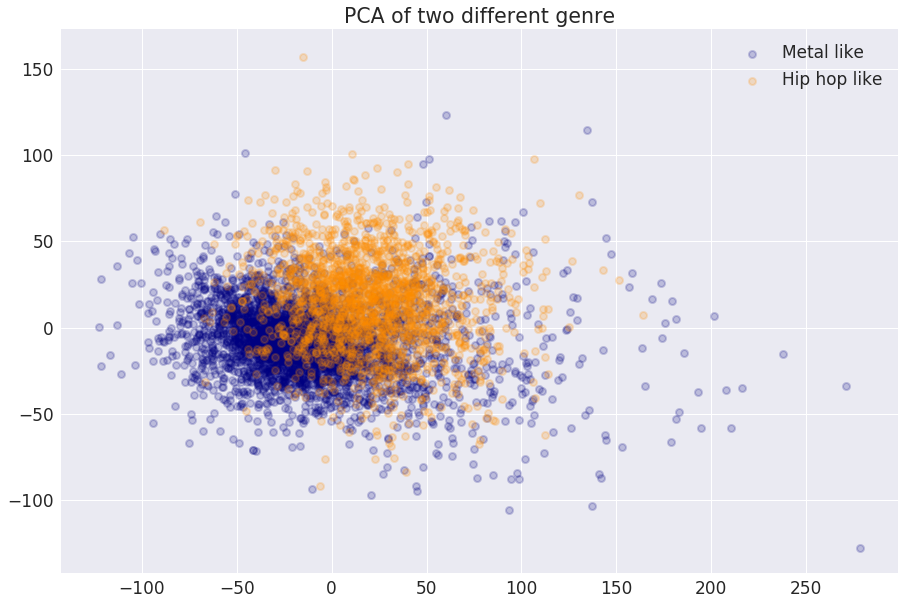

In [52]:
plt.figure(figsize=(15,10))
colors = ['navy', 'darkorange']
names = ["Metal like", "Hip hop like"]
y = segmTimb17["genre"]
lw = 2

for color, i, names in zip(colors, [1, 7], names):
    plt.scatter(pca[y == i, 0], pca[y == i, 1], color=color, alpha=.2, lw=lw, label = names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of two different genre')
plt.savefig('../docs/images/PCA_17.png')
plt.show()

## Metadata based
Using t-SNE the goal here is to plot the 2D space of song to see if we can see some clusters

In [57]:
%time song_2d = TSNE(n_components=2, n_iter=1000, random_state=42).fit_transform(X_tranform)

CPU times: user 17min 26s, sys: 30 s, total: 17min 56s
Wall time: 7min 46s


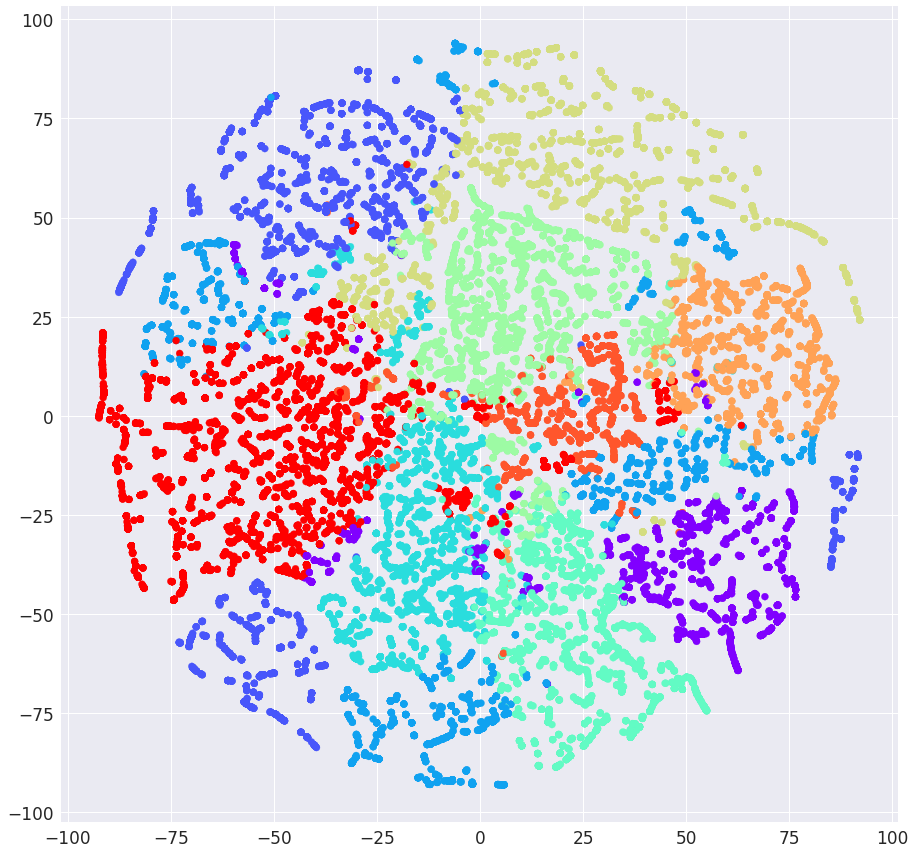

In [58]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
plot2d_matplotlib(song_2d, df_song2["genre"].apply(lambda g: colors[g]).values)

We can see from the scatter plot above that based on the meta data we can clusterize the music which mean that if we can train a model based on this metadata to clusterize our songs using content only

## Content based

In this part we will use the content of a sound and more especialy the timbre to pertict the genre of a particular song. For that purose we will train a simple Neural netork to clasify the song as a particular genre. As we dont have a clear label for each song we will use as label for the training the LDA topic repartition. This isn't a proper classifier, as we are not predicting the genre class, but rather the distribution of LDA topic learned above

By doing this we want our model to learn some structural information about the song content, here we trained it to find the topic genre distibution (as LDA), but we could have train it to learn directly the genre, or the artist we should still be able to use our network to extract meaningfull information from the tracks

### Raw content

We see that using the raw content to find similarity between song isn't enought as it doesn't enable us to clearly detect some clusters

We will futher split our top-30'000, into top 10'000 songs on which we will predict the genre and base our plots, and the remaining songs that we will use to train our model.

In [158]:
X_content = get_features(df_song2)
X_pred = X_content[:10000]
X_train = X_content[10000:]
Y_train = X_tranform[10000:]

genre_pred = df_song2["genre"].values[:10000]
infos_pred = df_song2.apply(build_info, axis=1).values[:10000]
urls_pred = df_song2.preview_url.values[:10000]

In [71]:
%time content_song_2d = TSNE(n_components=2, n_iter=1000, random_state=42).fit_transform(X_pred)

CPU times: user 8min 54s, sys: 11.5 s, total: 9min 5s
Wall time: 3min 10s


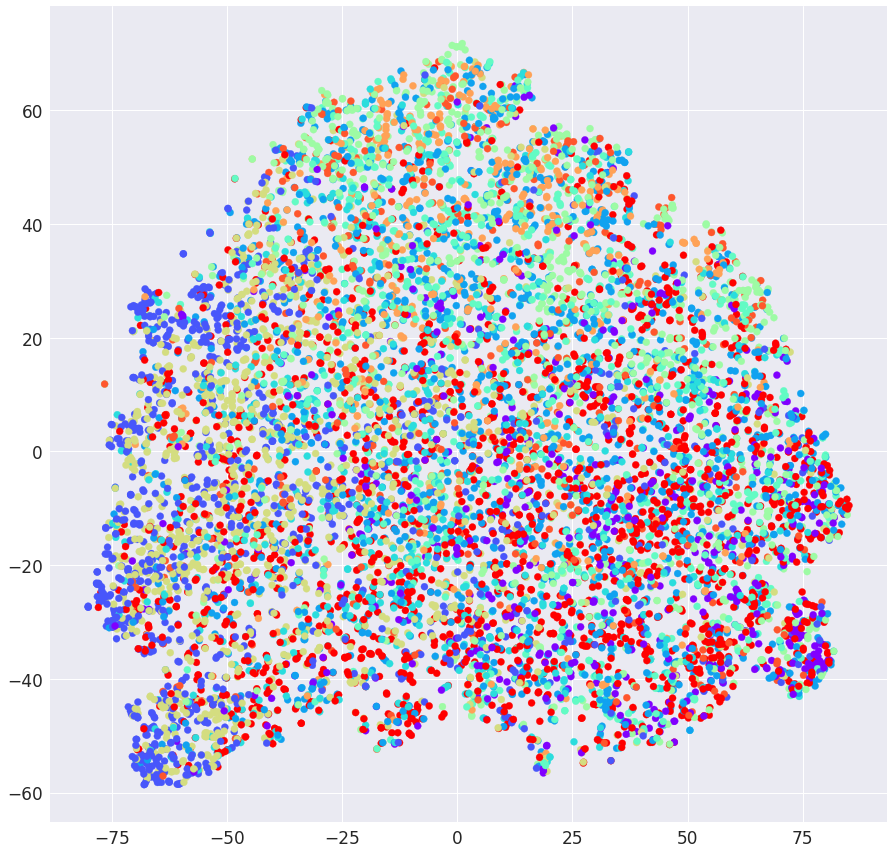

In [75]:
plot2d_matplotlib(content_song_2d, df_song2["genre"].apply(lambda g: colors[g]).values[:10000])

From the scatter plot above we see that it's clearly not enough and that to be able to clusterize the songs we need to process this raw data.

# Compress data using Autoencoder

Here we try without good result to learn some hidden pattern in data that could help us cluster our songs using a pure unsuppervised aproach. 

In [84]:
encoding_dim = 20

input_features = Input(shape=(60,))
hidden1 = Dense(40, activation='relu')(input_features)
encoded = Dense(encoding_dim, activation='relu')(hidden1)
hidden2 = Dense(40, activation='relu')(encoded)
decoded = Dense(60)(hidden2)
autoencoder = Model(input_features, decoded)
encoder = Model(input_features, encoded)

adam_optim = optimizers.adam(lr=0.01)
autoencoder.compile(optimizer=adam_optim, loss='mean_squared_error')

In [85]:
hist = autoencoder.fit(X_train, X_train, validation_split=0.2, epochs=100, verbose=0)

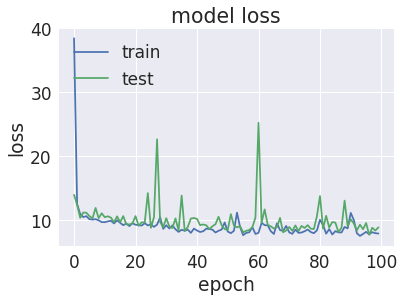

In [92]:
plot_keras_loss(hist)

In [94]:
compressed = encoder.predict(X_pred)

In [95]:
%time compressed_song_2d = TSNE(n_components=2, n_iter=1000, random_state=42).fit_transform(compressed)

CPU times: user 9min 8s, sys: 19.5 s, total: 9min 28s
Wall time: 3min 21s


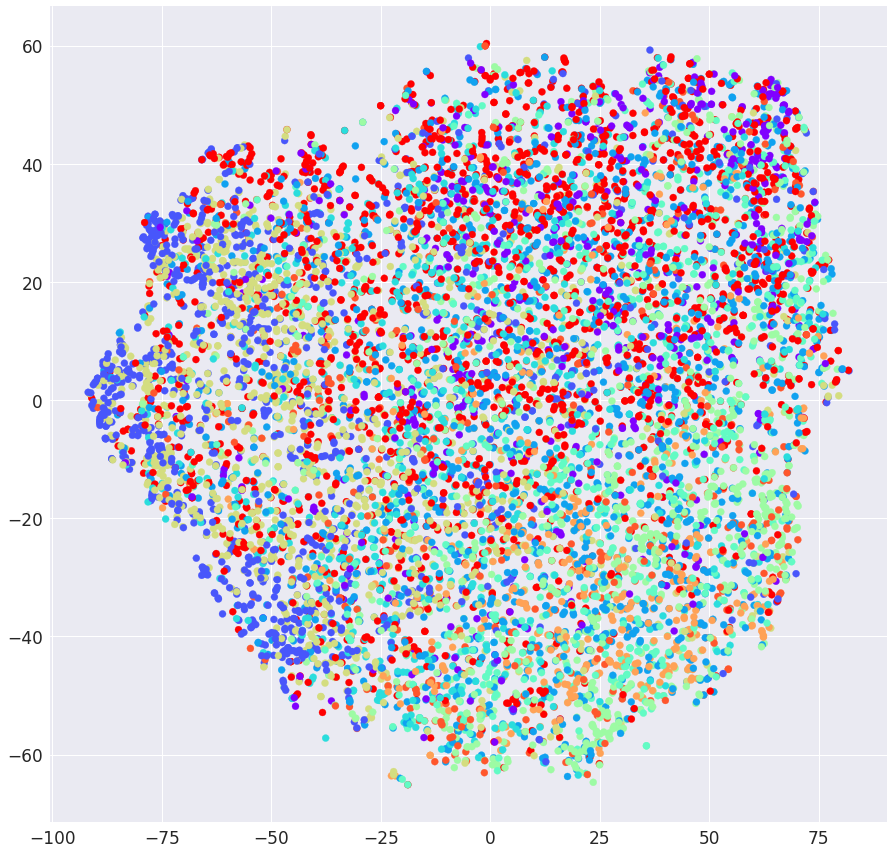

In [96]:
plot2d_matplotlib(compressed_song_2d, df_song2["genre"].apply(lambda g: colors[g]).values[:10000])

## Predict genre

In [153]:
input_features = Input(shape=(60,))
hidden1 = Dense(40, activation='relu')(input_features)
hidden2 = Dense(40, activation='relu')(hidden1)
hidden3 = Dense(20, activation='relu')(hidden2)
out = Dense(10, activation='softmax')(hidden3)

LDAModel = Model(input_features, out)

np.random.seed(42)
LDAModel.compile(loss='mean_squared_error', optimizer='adam')
hist = LDAModel.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=1000, verbose=0)

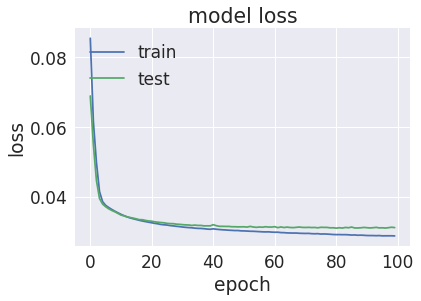

In [154]:
plot_keras_loss(hist)

In [155]:
predict = LDAModel.predict(X_pred)

In [156]:
%time predict_song_3d = TSNE(n_components=3, n_iter=1000, random_state=42).fit_transform(predict)

CPU times: user 19min 6s, sys: 22.7 s, total: 19min 29s
Wall time: 9min 19s


In [159]:
plot(predict_song_3d, genre_pred, infos=infos_pred,urls=urls_pred, filename='contentBased3D.html')

'file:///home/charles/Documents/EPFL/Ada/Ada/Project/contentBased3D.html'

In [160]:
plot2div(predict_song_3d, genre_pred, infos=infos_pred,urls=urls_pred)